<a href="https://colab.research.google.com/github/cstarke3/QMC_Final/blob/main/KineticEnergyAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def tests():
  """
  E_0 for the same attractive Gaussian potential that was used in previous homework assignments, with parameters V_0 = -4.0 and range R = 2.0.
  Note that even for two particles the ground-state energy below differs from the homework result because that calculation was performed for the 3D system with angular momentum 0, while now we are considering the system in 1D.
  """
  # v_0 = -4.0, R=2.0, n = 2, E_0 = -3.094
  # v_0 = -4.0, R=2.0, n = 3, E_0 = -9.738
  # v_0 = -4.0, R=2.0, n = 4, E_0 = -20.046

In [20]:
import numpy as np
import scipy.constants as const
import matplotlib as plt

class QMC: #I'm sure I am missing stuff on referencing inside the class and whatnot, but the structure should be right

    def __init__(self, V, particles, dim=1, min_replicas=500, max_replicas=2000, max_steps=1000, delta_t=0.1, xmin=-20, xmax=20, bins=200):
        self._V = V # potential function V(x) associated with the specific quantum system we are modeling
        self._dim = dim # number of dimensions (D=1 for this exercise)
        self._min_replicas = min_replicas # minimum number of replicas
        self._max_replicas = max_replicas # maximum number of replicas
        #self._seed = seed # seed value for the random number generator
        self._max_steps = max_steps # maximum number of time steps to run the simulation (τ0 = 1000)
        self._delta_t = delta_t # time step size (Δτ = 0.1)
        self._xmin = xmin # minimum value of the spatial coordinate (xmin = −20)
        self._xmax = xmax # maximum value of the spatial coordinate (xmax = 20)
        self._bins = bins # number of spatial bins for sorting the replicas during their sampling
        self.mass = 1
        self.hbar = 1 #changed to one

        self.particles = particles # number of particles
        self.replicas = dict()
        self.Energy = []
        self.total_count = [min_replicas*particles]
        self.count = np.zeros(self.particles)
        self.Kinetic = np.zeros(self.particles)



    def initialize(self, particles):
      partial_Energy = []

      for i in range(self.particles): # Create replica arrays assigned to individual particles
          self.replicas[i] = np.zeros((2, self._max_replicas))
          self.replicas[i][1,0:self._min_replicas] = 1

      for i in range(self.particles):
          self.count[i] = sum(self.replicas[i][1,:])

      for i in range(self.particles): # Finds the Energy from Eq, 2.32 and 2.33
          partial_Energy.append(self.Average_Potential(i))

      self.Energy.append(np.sum(partial_Energy))


    def Average_Potential(self, i): #Calulates the average potential for one set of replicas from
        sum = 0
        for k in range(int(self.count[i])): #I might be indexing wrong here, might be count-1; Could also switch this to N_max and not have to do a sort function, right now we need one though
            sum += self._V(self.replicas[i][0, k])
        return (1/self.count[i])*sum

    def Sort(self, i): # Sorts live replicas to the front of the array
        for k in range(int(self.count[i])): #sets dead replicas postions to 0
            if self.replicas[i][1,k] == 0:
                self.replicas[i][0,k] = 0

        transposed_array = list(zip(*self.replicas[i]))
        def custom_sort(item):
          return item[1]

        sorted_transposed_array = sorted(transposed_array, key=custom_sort)
        dummy_array = list(zip(*sorted_transposed_array))
        final_array = [dummy_array[0][::-1], dummy_array[1][::-1]]

        for k in range(self._max_replicas):
          self.replicas[i][0,k] = final_array[0][k]
          self.replicas[i][1,k] = final_array[1][k]#sorts in descending order to group live replicas to the front of the array


    def Count_func(self): #Counts the number of alive particles in the replica set associated with a particular particle
        for k in range(self.particles):
          self.count[k] = sum(self.replicas[k][1,:])


    def Walk(self, i): #Walks every replica associated with particle i according to Eq. 2.30
        sum = 0
        for k in range(int(self.count[i])):
            val = np.copy(self.replicas[i][0,k])
            self.replicas[i][0,k] = self.replicas[i][0,k] + np.sqrt(self._delta_t)*np.random.randn()
            val = val - self.replicas[i][0,k]
            sum += val
        self.Kinetic[i] = (1/self.count[i])*sum

    def Branch(self, i): #conducts the branching of the replicas
        Zed = 0
        Two = 0
        Three = 0
        index = 1
        for k in range(int(self.count[i])):
            #W = 1 - ((self._V(self.replicas[i][0,k]) - self.Average_Potential(i))/self.hbar)*self._delta_t
            W = 1 - (((self._V(self.replicas[i][0,k]) - (self.Energy[-1]/self.particles))/self.hbar))*self._delta_t
            W = int(W + np.random.uniform())
            m = min(W, 3)
            if m == 0:
               self.replicas[i][1, k] = 0
               self.replicas[i][0, k] = 0
               Zed += 1
            elif m == 2:
                self.replicas[i][1, int(self.count[i]+index)] = 1
                self.replicas[i][0, int(self.count[i]+index)] = self.replicas[i][0,k]
                index += 1
                Two += 1
            elif m == 3:
                self.replicas[i][1, int(self.count[i]+index)] = 1
                self.replicas[i][0, int(self.count[i]+index)] = self.replicas[i][0,k]
                self.replicas[i][1, int(self.count[i]+index+1)] = 1
                self.replicas[i][0, int(self.count[i]+index+1)] = self.replicas[i][0,k]
                index += 2
                Three += 1
        #print(Zed, Two, Three)
        #print(Two - Zed)

    def Energy_Step(self, i): #finds the next energy value based on the previous energy value
        self.total_count.append(np.sum(self.count))
        Kinetic_Total = np.sum(self.Kinetic)/(self.particles)
        #self.Energy.append(self.Energy[i-1] + (self.hbar/self._delta_t)*(1-(self.total_count[i-1]/self.total_count[i-2])))
        self.Energy.append((self.Energy[i-1] + (self.hbar/self._delta_t)*(1-(self.total_count[i-1]/self.total_count[i-2])))+((1/2)*self.mass*(np.absolute(Kinetic_Total)*self._delta_t)**2))


    def Test(self, i): #only run this if i is greater than a set number, 10 maybe?
        flag = 0
        sum = 0
        for k in range(10):
            sum += np.absolute(self.total_count[i] - self.total_count[k]) #Sum the count differences for the current count compared to the last 9
        avg = sum/10 #Average the count difference
        if avg <= 5: #5 here is the tolerance, not sure what a good value is or if there is a just a better way in general to run this test
            flag = 1
        return flag

    def Ground_State_Energy(self):
        self.initialize(self.particles)
        flag = 0
        if flag == 0:
            for t in range(1, self._max_steps):
              for k in range(self.particles):
                if t > 10:
                  flag = self.Test(k)
                self.Walk(k)
                self.Branch(k)
                self.Count_func()
                self.Sort(k)
              self.Energy_Step(t)

        return self.Energy[-1], self.Energy

In [3]:
!gdown 14mgfJyCBSvw01ctiK9H6V2JbjcGYNMFc
!unzip -o lib.zip

Downloading...
From: https://drive.google.com/uc?id=14mgfJyCBSvw01ctiK9H6V2JbjcGYNMFc
To: /content/lib.zip
100% 3.35k/3.35k [00:00<00:00, 13.1MB/s]
Archive:  lib.zip
   creating: lib/
  inflating: lib/operator.py         
  inflating: lib/potential.py        
  inflating: lib/riccati.py          
  inflating: lib/system.py           


In [26]:
from lib.system import *
sys = System()

from lib.potential import *

V = V_Gauss(sys, -4.0, 2.0)

def potential(x):
    return 2*x

val = QMC(V, 1, 10, max_steps=1000, delta_t = .1, max_replicas=2000)
Final_Energy, Energies = val.Ground_State_Energy()
print(Final_Energy)

<ipython-input-20-d538230cdd6d>:82: RuntimeWarning: divide by zero encountered in double_scalars
  self.Kinetic[i] = (1/self.count[i])*sum
<ipython-input-20-d538230cdd6d>:82: RuntimeWarning: invalid value encountered in double_scalars
  self.Kinetic[i] = (1/self.count[i])*sum
<ipython-input-20-d538230cdd6d>:117: RuntimeWarning: invalid value encountered in double_scalars
  self.Energy.append((self.Energy[i-1] + (self.hbar/self._delta_t)*(1-(self.total_count[i-1]/self.total_count[i-2])))+((1/2)*self.mass*(np.absolute(Kinetic_Total)*self._delta_t)**2))


nan


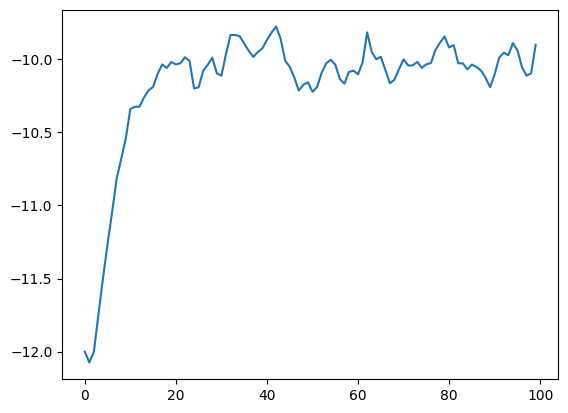

In [18]:
x = np.arange(0,100)
plt.plot(x, Energies)

In [22]:
print(np.average(Energies))

-9.998101881641816


In [ ]:
array = [
    [3, 7, 2, 0, 5, 0, 1, 8, 4, 6],
    [1, 0, 3, 4, 0, 6, 7, 2, 5, 8]
]

transposed_array = list(zip(*array))
def custom_sort(item):
    return item[1]

sorted_transposed_array = sorted(transposed_array, key=custom_sort)
sorted_array = list(zip(*sorted_transposed_array))

# Print the result
for row in sorted_array:
    print(row)

(7, 5, 3, 8, 2, 0, 4, 0, 1, 6)
(0, 0, 1, 2, 3, 4, 5, 6, 7, 8)


In [ ]:
sorted_array

[(7, 5, 3, 8, 2, 0, 4, 0, 1, 6), (0, 0, 1, 2, 3, 4, 5, 6, 7, 8)]

In [ ]:
sorted_array[1][::-1]

(8, 7, 6, 5, 4, 3, 2, 1, 0, 0)

In [ ]:
sorted_array[0][::-1]

(6, 1, 0, 4, 0, 2, 8, 3, 5, 7)

In [ ]:
final_array = [sorted_array[0][::-1], sorted_array[1][::-1]]

In [ ]:
for row in final_array:
    print(row)

(6, 1, 0, 4, 0, 2, 8, 3, 5, 7)
(8, 7, 6, 5, 4, 3, 2, 1, 0, 0)


In [ ]:
final_array

[(6, 1, 0, 4, 0, 2, 8, 3, 5, 7), (8, 7, 6, 5, 4, 3, 2, 1, 0, 0)]

In [ ]:
Energies

[-8.0,
 -18.0,
 -18.0,
 -17.99,
 -18.01002002002002,
 -18.049980059980058,
 -18.04002981122384,
 -18.04002981122384,
 -18.069910289311487,
 -18.04011882952996,
 -18.02019851080486,
 -18.03017855072502,
 -18.050118730186632,
 -18.109820222723947,
 -18.03069064804541,
 -18.08054109669945,
 -18.08054109669945,
 -18.06069982685818,
 -18.090520900416827,
 -18.03105608376668,
 -17.991175724843448,
 -17.971155704823428,
 -17.890914982656927,
 -17.931359876489083,
 -18.042135304485054,
 -18.032175145122505,
 -17.992294786199274,
 -18.032334826239314,
 -18.052275005700928,
 -18.002523761919832,
 -18.01252376191983,
 -18.032503781899848,
 -18.042473871630655,
 -18.082314509080852,
 -18.112076413842757,
 -18.14175000434721,
 -18.122026138469497,
 -18.141788984319298,
 -18.023445789053028,
 -17.89370527009095,
 -17.8532603762588,
 -17.78219438641108,
 -17.83331913078736,
 -17.823146190807705,
 -17.772229693862695,
 -17.854113010137006,
 -17.854113010137006,
 -17.884569862928885,
 -17.8845698629288